# Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from arsenal import iterview, timeit
from collections import Counter
from IPython.display import HTML
from genparse import CFG, FST, EPSILON, Float, CFGLM, add_EOS, prefix_transducer
from genparse.cfglm import locally_normalize, EOS, pcfg_check, explode, add_EOS, CharAlignedCFGLM
from genparse.util import LarkStuff, hf_tokenizer, about, show_grammar, normalize, bpe_wfst, display_table, bpe2term_approx, char2bpe_wfst
from genparse.inference import TraceSWOR
from genparse.steer import generation_tree

## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [46]:
lark_stuff = LarkStuff(r"""

start: NAME

NAME: /(a|b)*c/

""")
foo = lark_stuff.char_cfg(decay=.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

✔ PCFG


In [47]:
foo

Grammar {
  1.0: 0 → NAME
  1.0: NAME → ('NAME', 0)
  1.0: ('NAME', 1) → 
  0.03333333333333333: ('NAME', 0) → a ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → b ('NAME', 0)
  0.9333333333576115: ('NAME', 0) → c ('NAME', 1)
}

In [48]:
foo.cnf.language(3)

key,value
"('c',)",0.9333333333576115
"('b', 'c')",0.031111111111920383
"('b', 'b', 'c')",0.0010370370370640127
"('b', 'a', 'c')",0.0010370370370640127
"('a', 'c')",0.031111111111920383
"('a', 'b', 'c')",0.0010370370370640127
"('a', 'a', 'c')",0.0010370370370640127


In [49]:
lm = CFGLM(add_EOS(foo))

In [50]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 (('c',), 0.9333333333333406)
1 (('b', 'c'), 0.03111111111110799)
2 (('b', 'a', 'c'), 0.001037037037036821)
3 (('a', 'c'), 0.03111111111110799)
4 (('a', 'b', 'c'), 0.001037037037036821)
5 (('a', 'a', 'c'), 0.001037037037036821)
6 (('b', 'b', 'c'), 0.001037037037036821)
7 (('b', 'b', 'b', 'c'), 3.456790123455696e-05)
8 (('b', 'a', 'a', 'c'), 3.456790123455696e-05)
9 (('a', 'a', 'a', 'c'), 3.456790123455696e-05)
10 (('b', 'a', 'b', 'c'), 3.456790123455696e-05)
11 (('b', 'b', 'a', 'c'), 3.456790123455696e-05)
12 (('a', 'a', 'b', 'b', 'c'), 1.1522633744851077e-06)
13 (('a', 'b', 'a', 'a', 'b', 'c'), 3.840877914949944e-08)
14 (('a', 'b', 'b', 'c'), 3.456790123455696e-05)


In [82]:
H = hf_tokenizer()
about(H.fst)

states: 97312, trim: 97312


Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [83]:
#b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber
#about(b2c)

In [84]:
b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

('c',)
total weight of BPE sequences (i.e., ambiguity): 1.0


('b', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


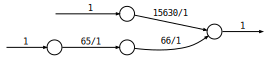

('b', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


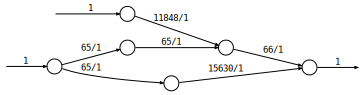

('b', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


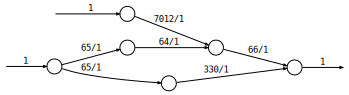

('a', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


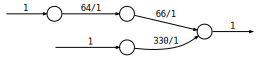

('a', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 4.0


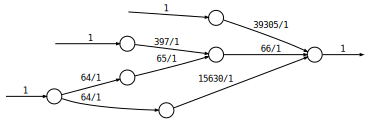

('a', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


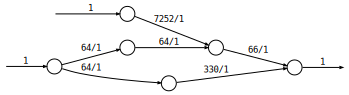

In [85]:
for x in foo.cnf.language(3):
    display(HTML('<hr/>'))
    print(x)
    bpe_x = b2c(None, x).epsremove.trim
    print('total weight of BPE sequences (i.e., ambiguity):', bpe_x.total_weight())
    display(bpe_x)
    print()

In [86]:
tmp = (b2c @ foo).trim()

In [87]:
L = 5

In [61]:
c = Float.chart()
for x, w, in tmp.cnf.language(5).items():
    y =  H.tokenizer.decode(x)
    if len(y) > L: continue    
    c[y] += w

In [62]:
ambig = Float.chart({x: b2c(None, x).total_weight() for x in c})

In [63]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [64]:
cc = Float.chart()
for x, w in foo.cnf.language(L+2).items():
    if len(x) > L: continue
    cc[''.join(x)] += w
#cc

In [65]:
ccc.assert_equal(cc, tol=1e-20)

In [66]:
#cc.metric(c)

In [67]:
#tmp.trim(bottomup_only=True)

In [68]:
#show_grammar(tmp, showzero=True)

In [69]:
#print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [70]:
#for q in c2t.states:      
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [71]:
#{x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [72]:
#len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [73]:
#tmp.cnf.language(4)

In [74]:
#show_grammar(tmp)

In [75]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()
pcfg_check(p)

✔ PCFG


In [76]:
lm2 = CFGLM(add_EOS(p))

In [77]:
#lm2.sample(verbose=1)

In [78]:
#context = (64,65,6485,39305)
context = (64,65,6485,)

In [79]:
char_context = H.tokenizer.decode(context)
char_context

'ababb'

In [80]:
df = []
for x, w in sorted(normalize(lm2.p_next(context)).items(), key=lambda kv: -kv[1]):
    df.append((x, (H.tokenizer.decode([x]) if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

,chars,prob
token_id,,
66,c,0.869821
64,a,0.033333
65,b,0.033333
15630,bc,0.028994
330,ac,0.028994
11848,bb,0.001111
397,ab,0.001111
7012,ba,0.001111
7252,aa,0.001111


In [81]:
Float.chart(normalize(lm.p_next(char_context)))

key,value
c,0.9333333333333405
a,0.03333333333332973
b,0.03333333333332973


## Lexing

In [ ]:
lark_stuff = LarkStuff(r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

""")

In [ ]:
foo = lark_stuff.char_cfg(.1)

In [ ]:
#foo['NAME'].trim().agenda()

In [ ]:
#foo.agenda()

In [ ]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [ ]:
#foo

In [ ]:
lm = CFGLM(add_EOS(foo))

In [ ]:
trace = TraceSWOR()
for _ in range(15):
   print('mass=', trace.root.mass)
   with trace:
       print(''.join(lm.sample(draw=trace)))

In [ ]:
cfg = lark_stuff.convert().renumber()

In [ ]:
c2t = lark_stuff.transducer(ignore='', decay=.0125); len(c2t.states)

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [ ]:
x = 'SELECT * FROM data'

In [ ]:
list(lark_stuff.lex(x))

However, this string can lex many different ways:

In [ ]:
ambig = (FST.from_string(x, Float) @ c2t).trim.project(1).epsremove.trim.to_cfg().cnf.language(15)

In [ ]:
#ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [ ]:
for y in ambig:
    v = cfg.prefix_weight(y)   # show all options with a nonzero prefix weight
    if v == 0: continue
    print(v, y)

In [ ]:
#((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [ ]:
#(P.T @ cfg).trim().cnf.language(100)

In [ ]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [ ]:
pcfg_check(pcfg_t)

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
lm = CFGLM(add_EOS(pcfg_t.cnf))

In [ ]:
for _ in range(10):
    print(''.join(lm.sample()))

In [ ]:
lm.p_next('SELECT * FROM ')

## BPE Basics

In [ ]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [ ]:
b2c = hf_tk.fst
len(b2c.states)

In [ ]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

In [ ]:
[tokenizer.decode([bb]) for bb in b]

In [ ]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

In [ ]:
c.trim

We can build this "transducer" more efficiently

In [ ]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [ ]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

In [ ]:
#bs.trim

The automaton below describes all the BPE sequences that generate the string `x`:

In [ ]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [ ]:
#for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## A Basic Alignment Algorithm

In [ ]:
lark_stuff = LarkStuff(r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
""")

foo = lark_stuff.char_cfg(.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(foo)

In [ ]:
print(''.join(lm.sample()))

In [ ]:
H = hf_tokenizer()

In [ ]:
bpe_lm = CharAlignedCFGLM(lm=lm, words={x for _, x in H.pairs}, eos=H.tokenizer.eos_token)

In [ ]:
lm.p_next('')

In [ ]:
bpe_lm.p_next('')

In [ ]:
lm.p_next('SELECT ')

In [ ]:
bpe_lm.p_next('SELECT ')

In [ ]:
ys = bpe_lm.sample(verbose=0)
ys

## Avoiding Distortion in Tokenization Alignment. 


Let $p$ be some original CFG-LM over character strings $a \in \mathcal{A}^*$.

Let $p'$ be the "BPE transform" of $p$; $p'$ is a distribution over BPE strings $b \in \mathcal{B}^*$.

The sets $\mathcal{A}^*$ and $\mathcal{B}^*$ are related through the functions $\mathrm{encode}$ and $\mathrm{decode}$.

We want 

$$
\forall a\colon\quad   p(a) = \sum_{b\colon\ \mathrm{decode}(b) = a} p'(b)
$$

We would like to define $p'$ such that this property holds because it ensures that the process:

1. $b \sim p'$
2. $a = \mathrm{decode}(b)$

generates $a$ that is distributed $p$.  We call the process **distortion-free** if these conditions are satisfied.

**Open question**: For any distribution $p$ and (segmentation-based) tokenization scheme, does a computationally efficient, incremental, distortion-free generative process exist?

It may be possible to satisfy the anti-distortion property in some ways that are "bad" because they would adversely affect the downstream components.  Consider the following **unwanted workaround** for BPE tokenization (which is a *segmentation* model).  In that case, we have, by construction, individual characters included in the token vocabulary.  This means that we can define a trivial segmentation that only takes unit-length segments.  This will not be the preferred prediction scheme of the LLM model -- it will prefer the segments that are more representative of those that would appear in this context in the training data.

This suggests that either the LM should be as unopinionated about the tokenization/segmentation as possible.  Or, it should attempt to match the canonical tokenization (in so far as one exists).  (Could the latter case lead to unwanted amplification?)

The below we explore some preliminary attempts to understand the distortion in the char-alignment adaptor (I might refer to this a "grafting" as well as a more global transduction-based approach).

$$\newcommand{\BtoA}[0]{\underset{\mathcal{B} \to \mathcal{A}}{\phi}}$$

The class `CharAlignedCFGLM` implements an LM $q$ over tokens based on the following conditional factorization:

$$
q(b_{N+1} \mid b_1, \ldots, b_N) \propto p( a_{N+1} \mid a_1 \cdots a_N )
$$

where $b_1, \ldots, b_N$ are a sequence of tokens ids, and $a_1, \ldots, a_N$ are their respective strings in $\mathcal{A}^*$ (i.e., $\left( b_k \BtoA \right) = B_k$ for each $k = 1, \ldots, N$).

The transduction model $\widehat{G} \overset{\mathrm{def}}{=} \BtoA \, G$

In [270]:
_cfg = CFG.from_string("""

1: S -> a
1: S -> a a
2: S -> a a a

""", Float)

alphabet = _cfg.V
tokens = {'a','aa','aaa', EOS}

c_lm = CFGLM(locally_normalize(_cfg, tol=1e-100).trim())

In [271]:
c_lm.cfg

Grammar {
  1: 0 → 1 ▪
  0.25: 1 → a
  0.25: 1 → a a
  0.5: 1 → a a a
}

In [272]:
a_lm = CharAlignedCFGLM(c_lm, tokens, EOS)

In [273]:
C, tracer_char = generation_tree(c_lm)
display_table([[C, tracer_char]])

key,value
"('a',)",0.25
"('a', 'a')",0.25
"('a', 'a', 'a')",0.5


In [274]:
A, tracer_aligned = generation_tree(a_lm)
display_table([[A, tracer_aligned]])

key,value
a,0.0855614973262032
aa,0.2032085561497326
aaa,0.7112299465240641


In [275]:
D_chunks, tracer_aligned_chunks = generation_tree(a_lm, chunked=True)
display_table([[D_chunks, tracer_aligned_chunks]])

key,value
"('a',)",0.0855614973262032
"('a', 'a')",0.08556149732620319
"('a', 'a', 'a')",0.17112299465240638
"('a', 'aa')",0.1283422459893048
"('aa',)",0.11764705882352941
"('aa', 'a')",0.23529411764705882
"('aaa',)",0.17647058823529413


The following WFST simulates the BPE's desire to create chunk from character sequences. (For correctness, we will require `tokens` to be both prefix closed and closed under last character substitution, as it ensures that no string is lost.)

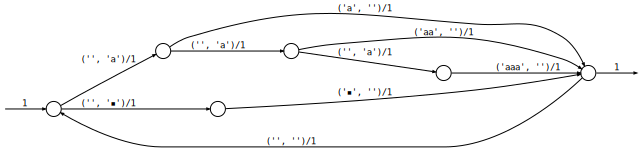

In [276]:
B = bpe_wfst((w, tuple(w)) for w in tokens)
B

We can push some specific character strings throught the transducer to see all of the ways that can be chunked.

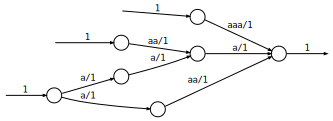

In [277]:
(B @ FST.from_string('aaa', Float)).trim.project(0).epsremove.trim

In [278]:
(B @ FST.from_string('aaa', Float)).trim.project(0).epsremove.trim.total_weight()

4.0

In [279]:
b_lm = CFGLM(locally_normalize((B @ c_lm.cfg).trim(), tol=1e-100).trim())

In [280]:
L = b_lm.cfg.language(10)

In [281]:
BB, tracer_bpe_chunks = generation_tree(b_lm)
display_table([[BB, tracer_bpe_chunks]])

key,value
"('a',)",0.0909090909090909
"('a', 'a')",0.0909090909090909
"('a', 'a', 'a')",0.1818181818181818
"('a', 'aa')",0.1818181818181818
"('aa',)",0.0909090909090909
"('aa', 'a')",0.1818181818181818
"('aaa',)",0.18181818181818182


In [282]:
PL = L.project(lambda y: ''.join(y).strip(EOS))
PL

key,value
a,0.0909090909090909
aa,0.1818181818181818
aaa,0.7272727272727273


One way to resolve the double-counting issues with the tranduction approach is to canonicalize the tokenization.  We can make this up post-hoc using a filter for whether or not the tokenization is greedy (aka a maximum-munch tokenization).

In [298]:
def max_munch(tokens):
    "Maximum-munch tokenizer for the finite set `tokens`."
    def t(a):
        if len(a) == 0: return ()
        for b in sorted(tokens, key=len, reverse=True):
            if a.startswith(b):
                return (b,) + t(a[len(b):])
        raise ValueError('bad token set')
    return t
def min_munch(tokens):
    "Minimum-munch tokenizer for the finite set `tokens`."
    def t(a):
        if len(a) == 0: return ()
        for b in sorted(tokens, key=len):
            if a.startswith(b):
                return (b,) + t(a[len(b):])
        raise ValueError('bad token set')
    return t

In [299]:
assert max_munch(tokens)('aaaaaa') == ('aaa','aaa')
assert max_munch(tokens)('aaaaa') == ('aaa','aa')
assert max_munch(tokens)('aaaa') == ('aaa','a')
assert max_munch(tokens)('aaa' 'aaa' 'aa') == ('aaa','aaa', 'aa')
assert min_munch(tokens)('aaaaaa') == ('a','a','a','a','a','a')

In [300]:
BB.filter(lambda b: max_munch(tokens)(''.join(b)) == tuple(b)).normalize()

key,value
"('a',)",0.24999999999999997
"('aa',)",0.24999999999999997
"('aaa',)",0.5


In [301]:
BB.filter(lambda b: min_munch(tokens)(''.join(b)) == tuple(b)).normalize()

key,value
"('a',)",0.25
"('a', 'a')",0.25
"('a', 'a', 'a')",0.5


In [290]:
display_table([[C.project(''.join), A, PL]], headings=['target', 'grafting-approximation', 'composition'])

In [160]:
#from genparse.util import char2bpe_single

In [159]:
#T_copy = FST.from_pairs([(w,w) for w in alphabet], Float).star().epsremove.trim
#T_copy

In [157]:
#G = (char2bpe_single((w,w) for w in tokens) * T_copy).trim
#G

In [158]:
#G.epsremove